# Prep

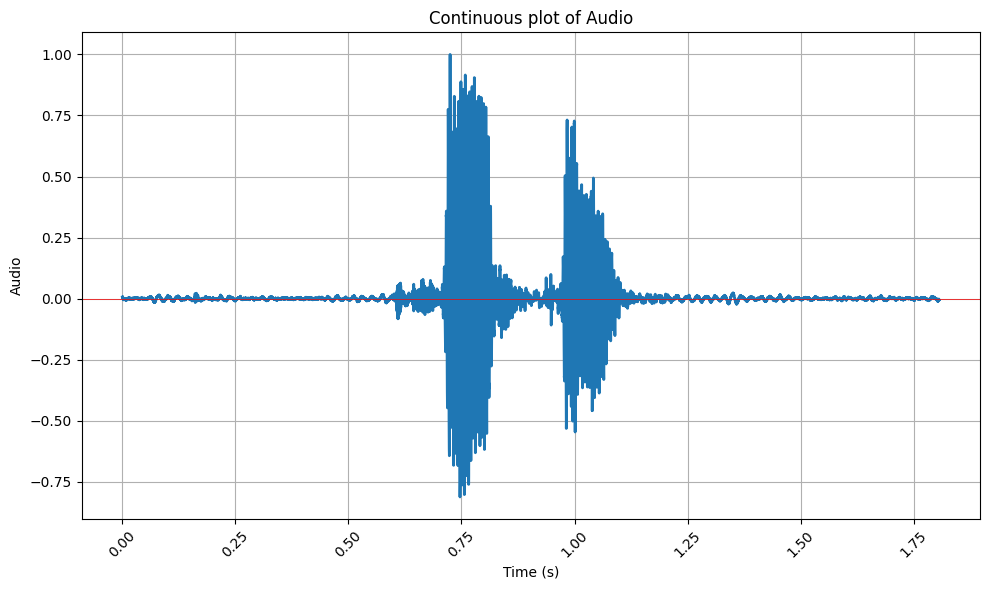

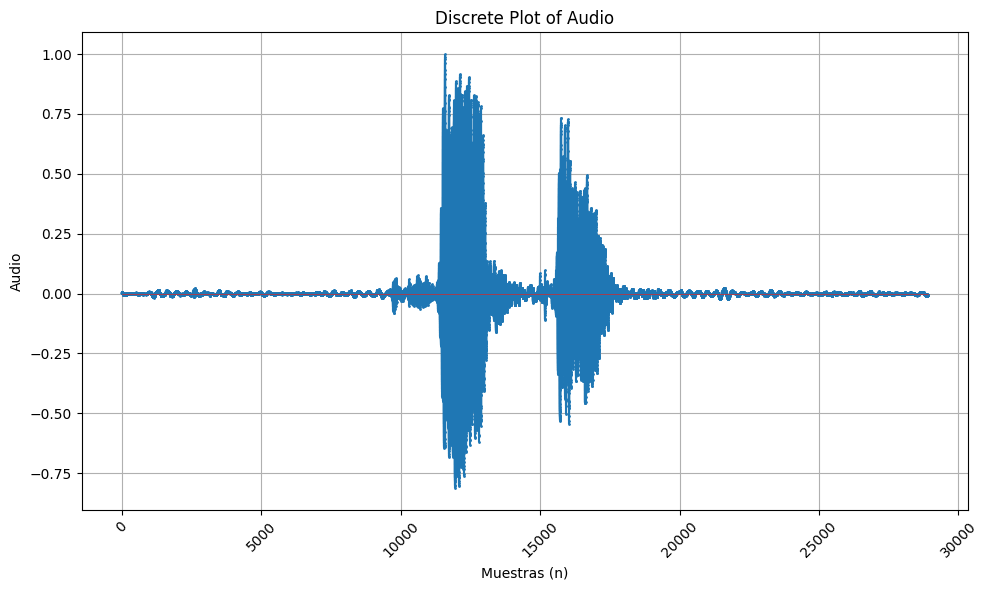

In [1]:
import sys
import numpy as np
import sounddevice as sd
import scipy.signal as signal
import librosa

sys.path.append("/Users/carlosedm10/projects/college/TDS")

from utils import continuous_time_plot, discrete_time_plot, split_signal_into_frames
from scipy.io import wavfile

# from scipy.signal import resample, spectrogram
from matplotlib import pyplot as plt


# Path to audio
audio_path = "/Users/carlosedm10/projects/college/TDS/P3/siete.wav"

# Read the audio file
freq, audio_data = wavfile.read(audio_path)

# Now we will make the audio Mono
if audio_data.ndim > 1:
    audio_data = audio_data.mean(axis=1)
    print("Audio is stereo, converting to mono")

audio_data = audio_data / 2**15

# Normalization (if your audio data is in integers and needs to be normalized)
audio_data = audio_data / np.max(np.abs(audio_data))


# Changing the audio frequency to 16kHz if necesary
# Target frequency
target_freq = 16000

if freq != 16000:
    print(f"Resampling audio from {freq}Hz to {target_freq}Hz")
    # Calculate new length of the sample
    new_length = round(len(audio_data) * target_freq / freq)

    # Resample the audio to the target frequency
    audio_data = signal.resample(audio_data, new_length)

# Time vector
t = np.arange(0, len(audio_data) / target_freq, 1 / target_freq)

# Plot the audio
continuous_time_plot(t, audio_data, variable_name="Audio")
discrete_time_plot(audio_data, variable_name="Audio")

# Exercise 1
Spectrogram V1

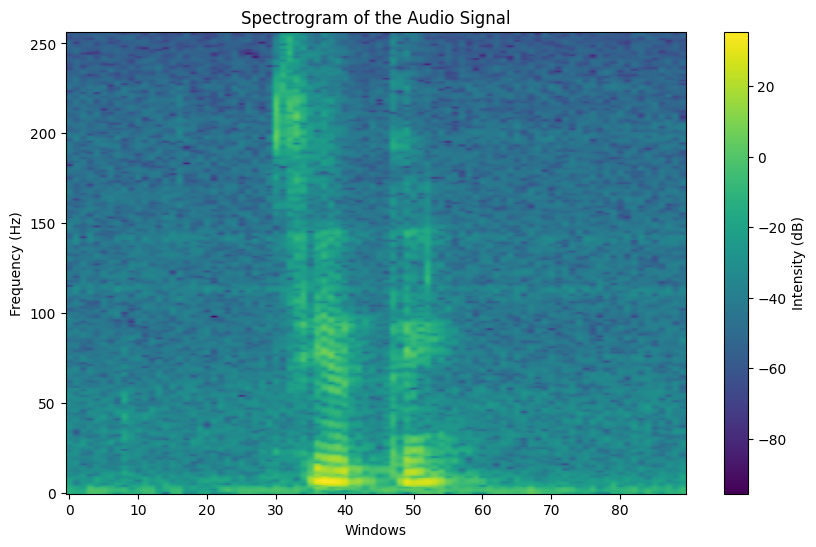

In [2]:
window_size = 0.02  # 32ms
window_overlap = 0  # No overlap
window_samples = round(window_size * freq)

windowed_frames = split_signal_into_frames(
    audio_data, freq, window_size, window_overlap
)
# Calculate the spectrogram
# nfft = round(freq * window_size)  # Number of FFT points
nfft = 512  # Number of FFT points

# Initialize the spectrogram matrix
spectrogram = np.zeros((nfft // 2 + 1, len(windowed_frames)))

# Compute the magnitude spectrogram
for i, frame in enumerate(windowed_frames):
    frame_fft = np.fft.rfft(frame, n=nfft)
    spectrogram[:, i] = np.abs(frame_fft)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(
    20 * np.log10(spectrogram),
    aspect="auto",
    origin="lower",
    # extent=[0, len(audio_data) / freq, 0, freq / 2],
    cmap="viridis",
)
plt.colorbar(label="Intensity (dB)")
plt.xlabel("Windows")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram of the Audio Signal")
plt.show()

# Exercise 2

### Spectrogram V2

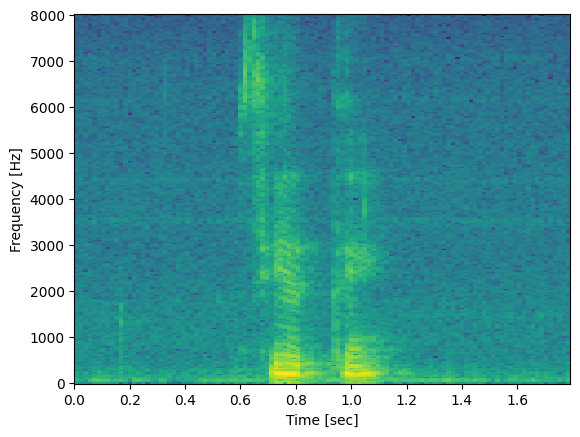

In [3]:
f, t, Sxx = signal.spectrogram(
    x=audio_data,
    fs=freq,
    noverlap=0.5,
    nfft=nfft,
)

plt.pcolormesh(
    t,
    f,
    20 * np.log10(Sxx),
)
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.show()

# Exercise 3
Melspectrogram

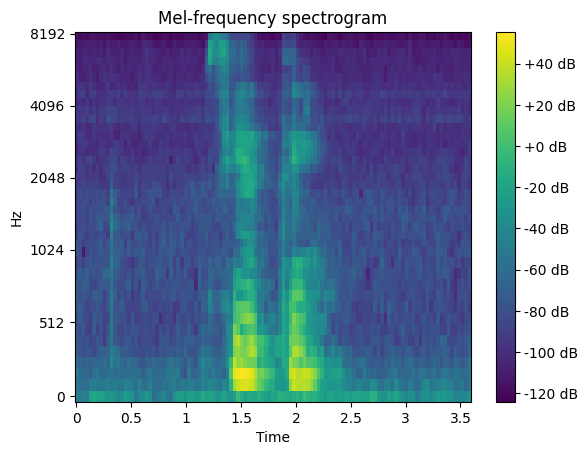

In [4]:
# Using the meshgrid function to plot the spectrogram and plotting it

# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(
    y=audio_data,
    sr=freq,
    win_length=512,
    hop_length=256,
    n_mels=40,
)

fig, ax = plt.subplots()
img = librosa.display.specshow(
    20 * np.log10(S),
    x_axis="time",
    y_axis="mel",
    sr=freq,
    ax=ax,
    cmap="viridis",
)
fig.colorbar(img, ax=ax, format="%+2.0f dB")
ax.set(title="Mel-frequency spectrogram")
plt.show()

# Exercise 4
VAD V1

[0 0 0 ... 0 0 0]


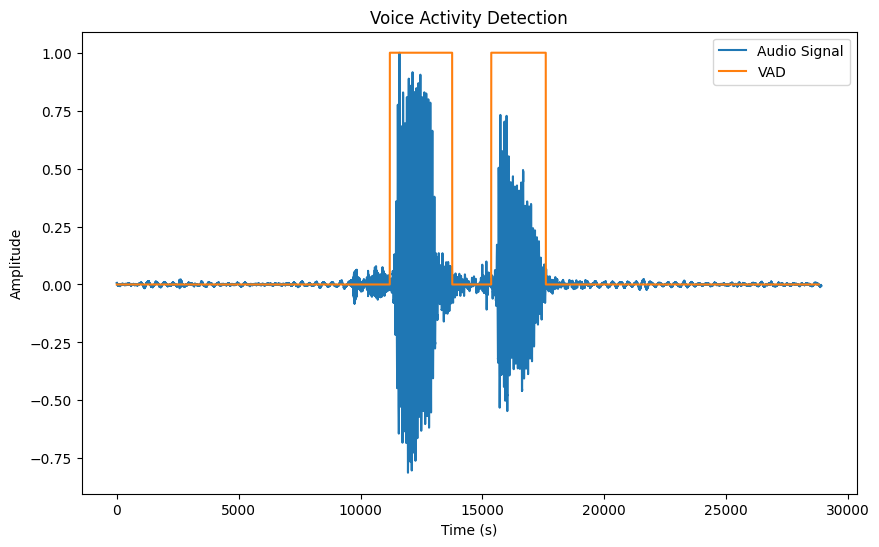

In [5]:
# Creating a VAD using the energy of the signal by frames
energy = np.sum(windowed_frames**2, axis=1)
threshold = 0.01 * np.max(energy)
vad = (energy > threshold).astype(int)
vad = np.repeat(vad, window_samples)
print(vad)

# Plot the VAD
plt.figure(figsize=(10, 6))
plt.plot(audio_data, label="Audio Signal")
plt.plot(vad * np.max(audio_data), label="VAD")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Voice Activity Detection")
plt.show()

Thresholds used: [1, 18]
Threshold used: 0.095
Number of numbers detected: 2
[0 0 0 ... 0 0 0]


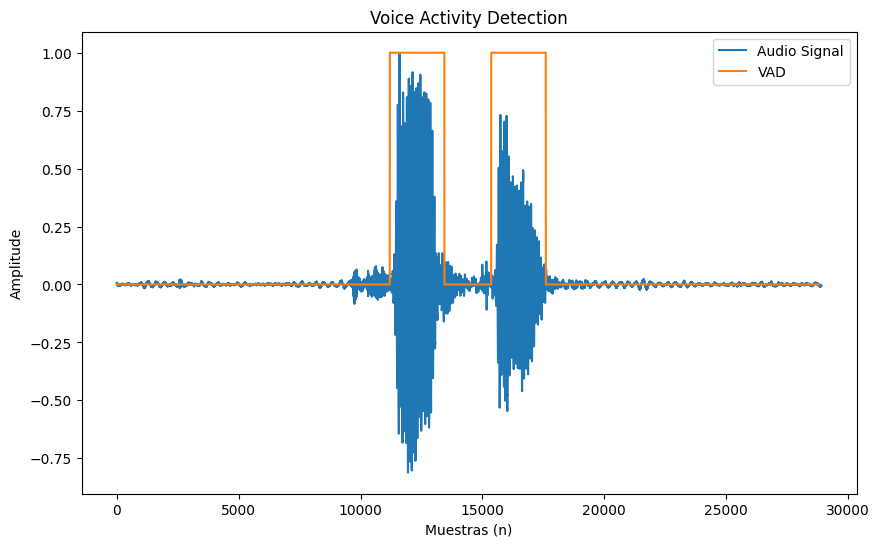

In [6]:
from utils import number_count_detector, export_numbers


voice = number_count_detector(audio_data, freq, window_size, window_overlap, count=2)
print(voice)
# Plot the VAD
plt.figure(figsize=(10, 6))
plt.plot(audio_data, label="Audio Signal")
plt.plot(voice * np.max(audio_data), label="VAD")
plt.xlabel("Muestras (n)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Voice Activity Detection")
plt.show()

# Export the audios:
export_numbers(audio_data, freq, voice, 2, "/Users/carlosedm10/projects/college/TDS/P3")